# XGBoost and Random Forest Regessors

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import time
from datetime import timedelta
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

## XGBoost

### Load Split Data

In [2]:
X_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_train.csv')
X_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_val.csv')
y_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_val.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_test.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/y_test.csv')


In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104621 entries, 0 to 104620
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   hour                    104621 non-null  int64  
 1   day_of_week             104621 non-null  int64  
 2   is_morning_rush         104621 non-null  int64  
 3   is_evening_rush         104621 non-null  int64  
 4   rate_of_change          104621 non-null  float64
 5   rate_of_change_lag1     104621 non-null  float64
 6   rolling_mean_4          104621 non-null  float64
 7   rolling_std_4           104621 non-null  float64
 8   avg_trip_duration       104621 non-null  float64
 9   median_trip_duration    104621 non-null  float64
 10  electric_bike_count     104621 non-null  float64
 11  member_count            104621 non-null  float64
 12  lat                     104621 non-null  float64
 13  lng                     104621 non-null  float64
 14  borough_encoded     

In [4]:
X_train.head()

,hour,day_of_week,is_morning_rush,is_evening_rush,rate_of_change,rate_of_change_lag1,rolling_mean_4,rolling_std_4,avg_trip_duration,median_trip_duration,...,total_historical_rides,avg_trip_duration_hist,std_trip_duration,member_proportion_hist,temp,windspeed,is_raining,classic_bike_count,casual_count,borough_manhattan
0,8,3,1,0,4.0,2.0,1.75,2.629956,11.875000,5.25,...,1363.0,12.225972,6.679543,0.903155,80.0,4.6,0,0.0,0.0,1
1,8,3,1,0,3.0,1.0,2.75,1.258306,6.125000,6.50,...,1620.0,11.913889,7.402015,0.770370,80.0,4.6,0,2.0,2.0,1
2,8,3,1,0,1.0,0.0,0.75,0.500000,8.000000,8.00,...,336.0,10.208333,6.456841,0.883929,80.0,4.6,0,0.0,1.0,1
3,8,3,1,0,3.0,3.0,1.25,2.061553,12.333333,13.00,...,806.0,9.381514,6.502693,0.842432,80.0,4.6,0,2.0,0.0,0
4,8,3,1,0,-4.0,0.0,-1.50,1.732051,6.700000,6.00,...,1109.0,9.482867,6.344764,0.866546,80.0,4.6,0,4.0,0.0,1


### XGBoost Regressor

In [6]:
# Handle target variable
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0] if y_train.shape[1] == 1 else y_train['cumulative_bikes']
if isinstance(y_val, pd.DataFrame):
    y_val = y_val.iloc[:, 0] if y_val.shape[1] == 1 else y_val['cumulative_bikes']

print(f"Train set: {X_train.shape}, Val set: {X_val.shape}")
print(f"Features: {list(X_train.columns)}")

Train set: (104621, 26), Val set: (34874, 26)
Features: ['hour', 'day_of_week', 'is_morning_rush', 'is_evening_rush', 'rate_of_change', 'rate_of_change_lag1', 'rolling_mean_4', 'rolling_std_4', 'avg_trip_duration', 'median_trip_duration', 'electric_bike_count', 'member_count', 'lat', 'lng', 'borough_encoded', 'distance_from_center', 'total_historical_rides', 'avg_trip_duration_hist', 'std_trip_duration', 'member_proportion_hist', 'temp', 'windspeed', 'is_raining', 'classic_bike_count', 'casual_count', 'borough_manhattan']


In [12]:
# Hyperparameter grid
params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 9, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}



In [18]:
print("Starting hyperparameter tuning...")
print(f"Testing {50} parameter combinations with {3}-fold CV = {50*3} total fits")
print("-" * 50)

# Create an instance of the model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


# Fit the model to the training data
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

elapsed_time = end_time - start_time

print("\n" + "="*50)
print(f"Hyperparameter tuning completed in {timedelta(seconds=int(elapsed_time))}")
print(f"({elapsed_time:.2f} seconds)")
print("="*50)

print("\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV score: {random_search.best_score_:.4f}")

Starting hyperparameter tuning...
Testing 50 parameter combinations with 3-fold CV = 150 total fits
--------------------------------------------------
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Hyperparameter tuning completed in 0:20:53
(1253.70 seconds)

Best parameters:
  subsample: 0.6
  reg_lambda: 1.5
  reg_alpha: 0
  n_estimators: 300
  min_child_weight: 1
  max_depth: 9
  learning_rate: 0.05
  gamma: 0.3
  colsample_bytree: 1.0

Best CV score: -46.9924


In [19]:
best_model = random_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

In [20]:
# Evaluation
def evaluate_model(y_true, y_pred, dataset):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")

    return {'rmse': rmse, 'mae': mae, 'r2': r2}

train_metrics = evaluate_model(y_train, y_train_pred, "TRAIN")
val_metrics = evaluate_model(y_val, y_val_pred, "VALIDATION")


TRAIN Metrics:
  RMSE: 3.8801
  MAE:  2.7986
  R²:   0.9171

VALIDATION Metrics:
  RMSE: 7.3090
  MAE:  4.6223
  R²:   0.6930


In [21]:
# Feature importance
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance_df.head(15))


Top 15 Most Important Features:
                   feature  importance
6           rolling_mean_4    0.209277
15    distance_from_center    0.096917
14         borough_encoded    0.094369
0                     hour    0.089933
13                     lng    0.084766
12                     lat    0.066704
18       std_trip_duration    0.052280
16  total_historical_rides    0.051071
17  avg_trip_duration_hist    0.046311
19  member_proportion_hist    0.044315
22              is_raining    0.018980
20                    temp    0.018942
4           rate_of_change    0.017695
7            rolling_std_4    0.016998
1              day_of_week    0.014995


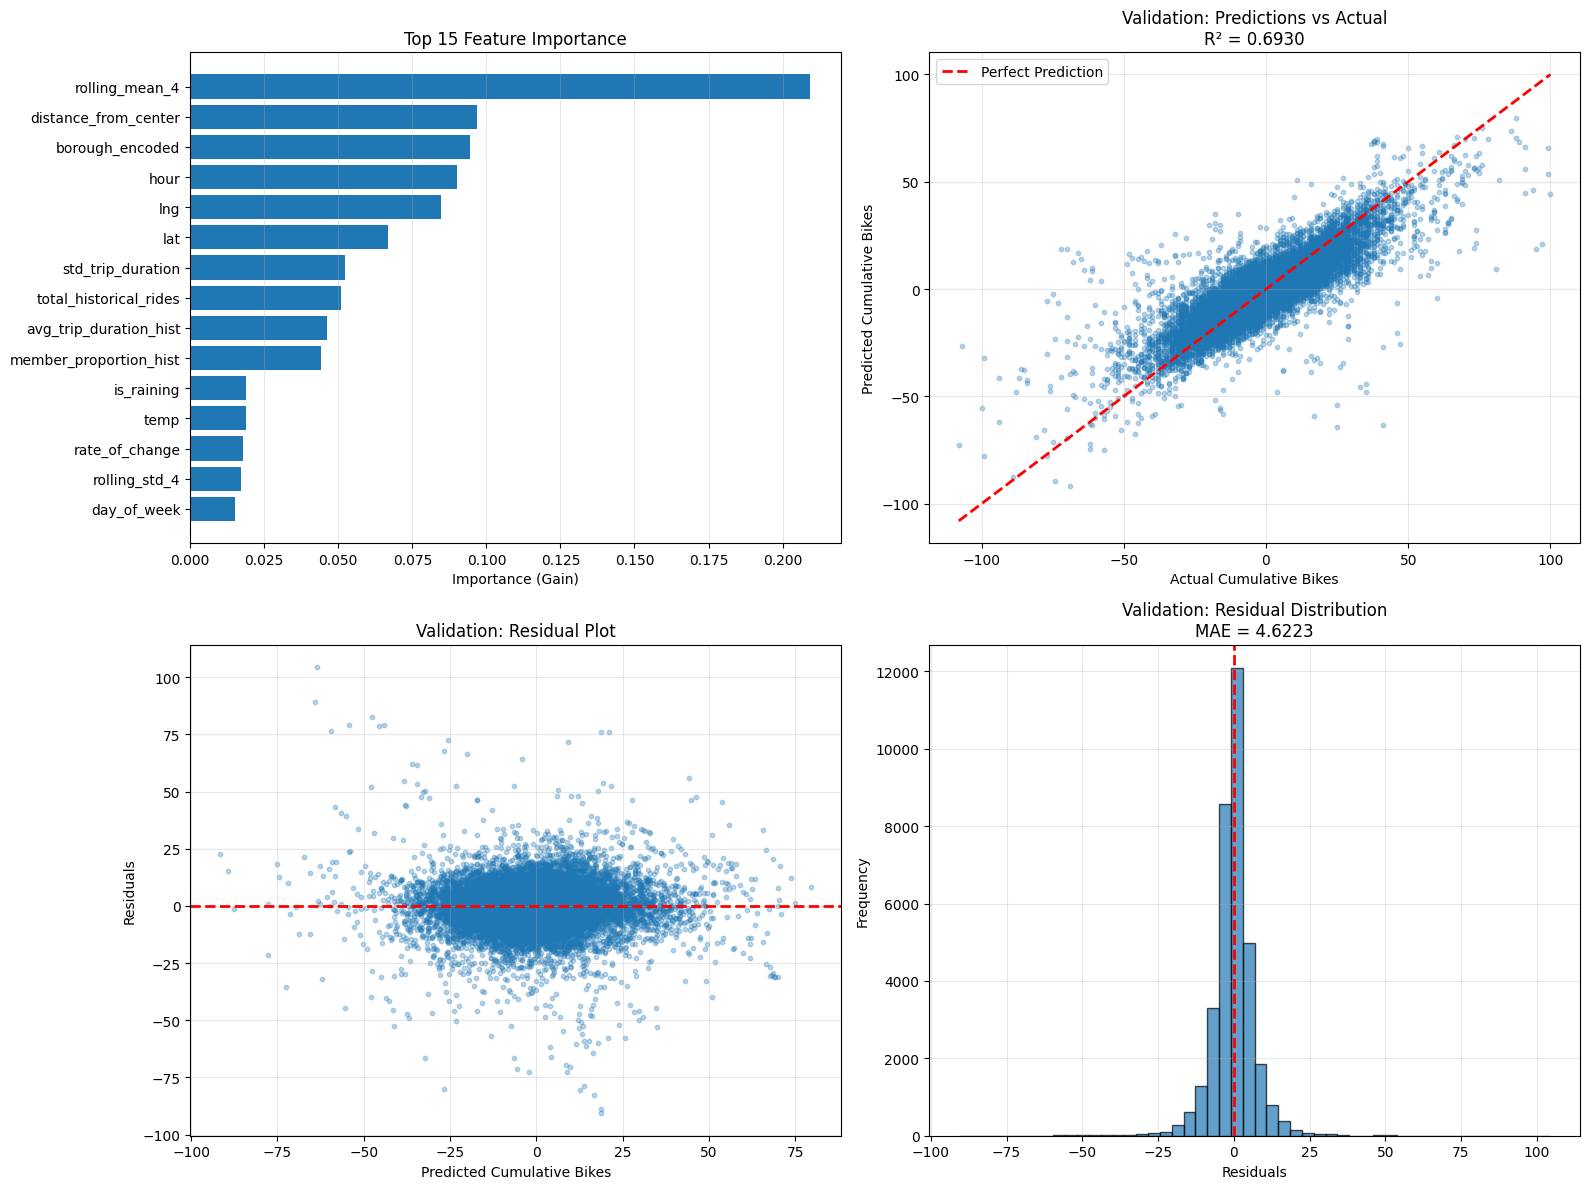

In [22]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Feature Importance
ax1 = axes[0, 0]
top_features = feature_importance_df.head(15)
ax1.barh(range(len(top_features)), top_features['importance'])
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Importance (Gain)')
ax1.set_title('Top 15 Feature Importance')
ax1.grid(axis='x', alpha=0.3)

# 2. Predictions vs Actual
ax2 = axes[0, 1]
ax2.scatter(y_val, y_val_pred, alpha=0.3, s=10)
min_val = min(y_val.min(), y_val_pred.min())
max_val = max(y_val.max(), y_val_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Cumulative Bikes')
ax2.set_ylabel('Predicted Cumulative Bikes')
ax2.set_title(f'Validation: Predictions vs Actual\nR² = {val_metrics["r2"]:.4f}')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Residuals
ax3 = axes[1, 0]
residuals = y_val - y_val_pred
ax3.scatter(y_val_pred, residuals, alpha=0.3, s=10)
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Predicted Cumulative Bikes')
ax3.set_ylabel('Residuals')
ax3.set_title('Validation: Residual Plot')
ax3.grid(alpha=0.3)

# 4. Residual Distribution
ax4 = axes[1, 1]
ax4.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax4.axvline(x=0, color='r', linestyle='--', lw=2)
ax4.set_xlabel('Residuals')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Validation: Residual Distribution\nMAE = {val_metrics["mae"]:.4f}')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

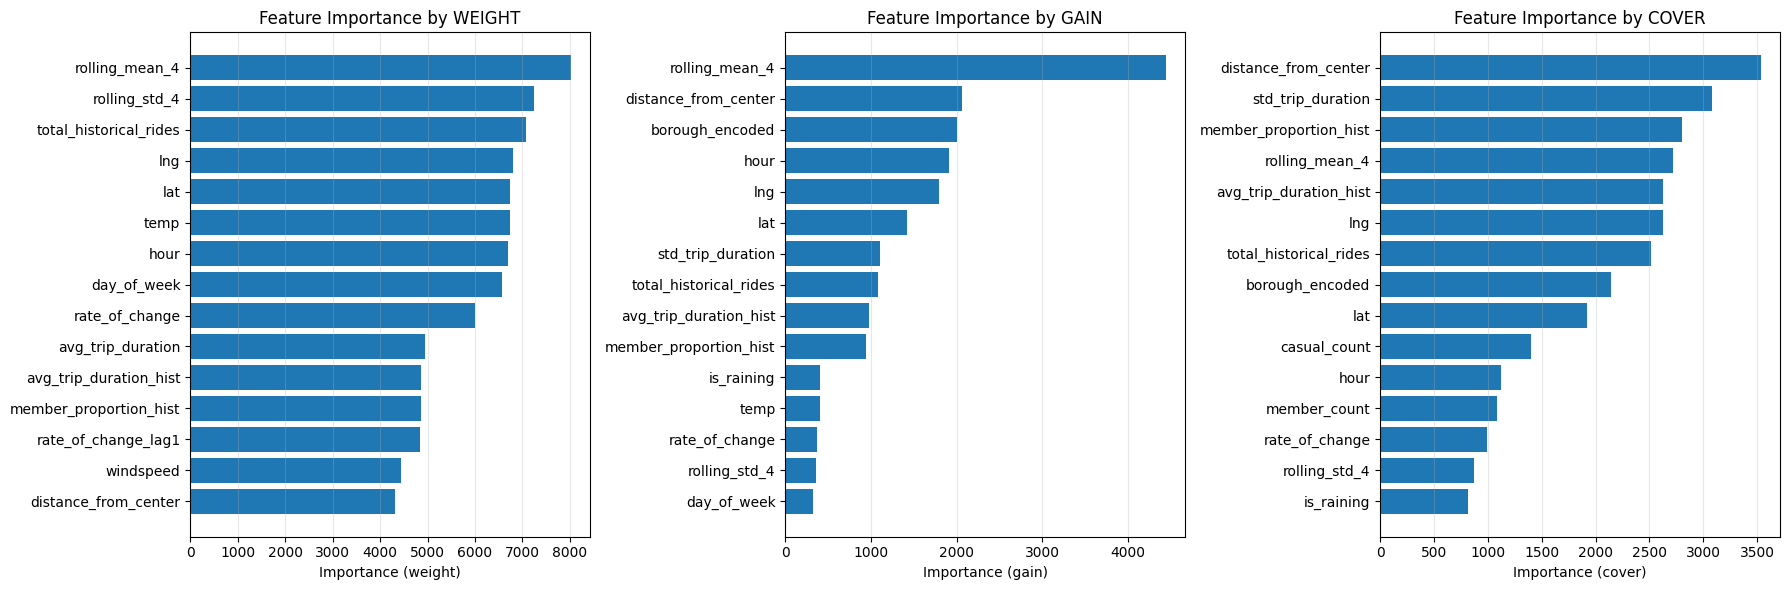

In [23]:
# Detailed feature importance by type
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

importance_types = ['weight', 'gain', 'cover']
for idx, imp_type in enumerate(importance_types):
    booster = best_model.get_booster()
    importance_dict = booster.get_score(importance_type=imp_type)

    imp_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    }).sort_values('importance', ascending=False).head(15)

    axes[idx].barh(range(len(imp_df)), imp_df['importance'])
    axes[idx].set_yticks(range(len(imp_df)))
    axes[idx].set_yticklabels(imp_df['feature'])
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel(f'Importance ({imp_type})')
    axes[idx].set_title(f'Feature Importance by {imp_type.upper()}')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


In [26]:
# Summary
print("="*50)
print("SUMMARY")
print("="*50)
print(f"Best CV Score (neg MSE): {random_search.best_score_:.4f}")
print(f"\nTrain RMSE: {train_metrics['rmse']:.4f}, R²: {train_metrics['r2']:.4f}")
print(f"Val RMSE:   {val_metrics['rmse']:.4f}, R²: {val_metrics['r2']:.4f}")

if train_metrics['r2'] - val_metrics['r2'] > 0.1:
    print("\nWarning: Possible overfitting detected")
else:
    print("\n✓ Model shows good generalization")

SUMMARY
Best CV Score (neg MSE): -46.9924

Train RMSE: 3.8801, R²: 0.9171
Val RMSE:   7.3090, R²: 0.6930



## Random Forest

In [32]:
# Hyperparameter grid
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 67],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False],
    'max_samples': [0.7, 0.8, 0.9, None]  # Only used if bootstrap=True
}

print("Hyperparameter search space defined")

Hyperparameter search space defined


In [33]:
import sys

print("="*50)
print("RANDOM FOREST HYPERPARAMETER TUNING")
print("="*50)

# Initialize model
rf_model = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    verbose=0
)


sys.stdout.flush()

# Tune hyperparameters
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_params,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=2,
    verbose=3,  # Changed to 3 for maximum verbosity
    random_state=42,
    n_jobs=-1
)

print(f"Testing 20 parameter combinations with 2-fold CV = 40 total fits")
print("Progress will update after each fit completes...")
print("-" * 50)

# Train model
rf_start_time = time.time()
rf_random_search.fit(X_train, y_train)
rf_end_time = time.time()

rf_elapsed_time = rf_end_time - rf_start_time
print("\n" + "="*50)
print(f"✓ Random Forest tuning completed in {timedelta(seconds=int(rf_elapsed_time))}")
print("="*50)

RANDOM FOREST HYPERPARAMETER TUNING
Testing 20 parameter combinations with 2-fold CV = 40 total fits
Progress will update after each fit completes...
--------------------------------------------------
Fitting 2 folds for each of 20 candidates, totalling 40 fits
⏱️  Still running... Elapsed: 0:04:00
⏱️  Still running... Elapsed: 0:04:00
⏱️  Still running... Elapsed: 0:05:00
⏱️  Still running... Elapsed: 0:05:00
⏱️  Still running... Elapsed: 0:06:00
⏱️  Still running... Elapsed: 0:06:00
⏱️  Still running... Elapsed: 0:07:00
⏱️  Still running... Elapsed: 0:07:00
⏱️  Still running... Elapsed: 0:08:00
⏱️  Still running... Elapsed: 0:08:00
⏱️  Still running... Elapsed: 0:09:00
⏱️  Still running... Elapsed: 0:09:00
⏱️  Still running... Elapsed: 0:10:00
⏱️  Still running... Elapsed: 0:10:00
⏱️  Still running... Elapsed: 0:11:00
⏱️  Still running... Elapsed: 0:11:00
⏱️  Still running... Elapsed: 0:12:00
⏱️  Still running... Elapsed: 0:12:00
⏱️  Still running... Elapsed: 0:13:00
⏱️  Still runnin

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
12 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py", line 431, in fit
    raise ValueError(
ValueError:

⏱️  Still running... Elapsed: 0:24:00
⏱️  Still running... Elapsed: 0:24:00
⏱️  Still running... Elapsed: 0:25:00
⏱️  Still running... Elapsed: 0:25:00

✓ Random Forest tuning completed in 0:21:51


In [34]:
# Random Forest predictions
best_rf_model = rf_random_search.best_estimator_

y_train_pred_rf = best_rf_model.predict(X_train)
y_val_pred_rf = best_rf_model.predict(X_val)

In [35]:
print("="*50)
print("RANDOM FOREST EVALUATION")
print("="*50)

train_metrics_rf = evaluate_model(y_train, y_train_pred_rf, "RF TRAIN")
val_metrics_rf = evaluate_model(y_val, y_val_pred_rf, "RF VALIDATION")

RANDOM FOREST EVALUATION

RF TRAIN Metrics:
  RMSE: 2.4506
  MAE:  1.5751
  R²:   0.9669

RF VALIDATION Metrics:
  RMSE: 7.4236
  MAE:  4.6577
  R²:   0.6833


In [36]:
# Random Forest feature importance
rf_importance = best_rf_model.feature_importances_
rf_feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_importance
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features (Random Forest):")
print(rf_feature_importance_df.head(15))


Top 15 Most Important Features (Random Forest):
                   feature  importance
6           rolling_mean_4    0.269045
13                     lng    0.105618
15    distance_from_center    0.082902
12                     lat    0.074271
16  total_historical_rides    0.063989
19  member_proportion_hist    0.049394
0                     hour    0.047170
18       std_trip_duration    0.045243
17  avg_trip_duration_hist    0.041445
5      rate_of_change_lag1    0.036415
7            rolling_std_4    0.027282
20                    temp    0.024306
3          is_evening_rush    0.022832
2          is_morning_rush    0.021038
1              day_of_week    0.019222


## Model Comparison

In [40]:
print("\n" + "="*50)
print("MODEL COMPARISON: XGBoost vs Random Forest")
print("="*50)

comparison_df = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest'],
    'Train_RMSE': [train_metrics['rmse'], train_metrics_rf['rmse']],
    'Train_MAE': [train_metrics['mae'], train_metrics_rf['mae']],
    'Train_R2': [train_metrics['r2'], train_metrics_rf['r2']],
    'Val_RMSE': [val_metrics['rmse'], val_metrics_rf['rmse']],
    'Val_MAE': [val_metrics['mae'], val_metrics_rf['mae']],
    'Val_R2': [val_metrics['r2'], val_metrics_rf['r2']]
})

print(comparison_df.to_string(index=False))

# Determine best model based on validation RMSE
if val_metrics['rmse'] < val_metrics_rf['rmse']:
    best_model_name = "XGBoost"
    final_best_model = best_model
    best_val_metrics = val_metrics
else:
    best_model_name = "Random Forest"
    final_best_model = best_rf_model
    best_val_metrics = val_metrics_rf

print(f"\n Best model: {best_model_name} (Validation RMSE: {best_val_metrics['rmse']:.4f})")


MODEL COMPARISON: XGBoost vs Random Forest
        Model  Train_RMSE  Train_MAE  Train_R2  Val_RMSE  Val_MAE   Val_R2
      XGBoost    3.880086   2.798567  0.917146  7.308978 4.622286 0.692981
Random Forest    2.450602   1.575093  0.966950  7.423623 4.657709 0.683274

 Best model: XGBoost (Validation RMSE: 7.3090)


## Save Best XGBoost Model for Future Tuning

In [44]:
# Save XGBoost to Google Drive
import shutil
import os

# Create a folder for your model
save_path = '/content/drive/MyDrive/Colab Notebooks/'
os.makedirs(save_path, exist_ok=True)

# Save XGBoost model and search results
files_to_save = [
    'xgboost_model.json',
    'xgboost_search_results.pkl',
]

for file in files_to_save:
    if os.path.exists(file):
        shutil.copy(file, save_path)
        print(f"✓ Saved {file} to Google Drive")
    else:
        print(f"⚠️  {file} not found, skipping")

print(f"\n✓ XGBoost files saved to: {save_path}")
print("Files will persist in your Google Drive!")

✓ Saved xgboost_model.json to Google Drive
✓ Saved xgboost_search_results.pkl to Google Drive

✓ XGBoost files saved to: /content/drive/MyDrive/Colab Notebooks/
Files will persist in your Google Drive!


In [43]:
# Load model

# Load the search results
#save_path = '/content/drive/MyDrive/Colab Notebooks/'
#xgb_search = joblib.load(save_path + 'xgboost_search_results.pkl')

# Load the best model
#best_xgb_model = xgb.XGBRegressor()
#best_xgb_model.load_model(save_path + 'xgboost_model.json')

#print("✓ Loaded XGBoost search results and best model")
#print(f"Best score from previous search: {xgb_search.best_score_:.4f}")
#print(f"Best parameters:\n{xgb_search.best_params_}")

#View all previous hyperparameter combinations tried
# This shows what you already tested
#results_df = pd.DataFrame(xgb_search.cv_results_)

# Show top 10 parameter combinations
#top_results = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')
#print("Top 10 parameter combinations from previous search:")
#print(top_results.head(10))